In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from src.losses import sse, mse
from src.test_models.VGAN import VGAN,Generator,Encoder,resample,gradient_penalty_loss

from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense,Concatenate,Input,Lambda,Activation
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.backend as K
from src.keras_callbacks import PrintHistory,Update_k
# from tabulate import tabulate

Using TensorFlow backend.


In [2]:
config,_ = get_config()

# Boilerplate
setattr(config, 'proj_root', '/home/elijahc/projects/vae')
setattr(config, 'log_dir', '/home/elijahc/projects/vae/logs')
setattr(config, 'dev_mode',True)
# setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-01-17/')

# Architecture Params
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 10)
setattr(config, 'y_dim', 10)

# Training Params
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs', 100)
setattr(config, 'monitor', 'val_loss')
setattr(config, 'min_delta', 0.5)
setattr(config, 'optimizer', 'adam')

# Loss Weights
setattr(config, 'xcov', 0)
setattr(config, 'recon', 10)
setattr(config, 'xent', 10)

In [3]:
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
vars(config)

{'batch_size': 512,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': True,
 'enc_layers': [3000, 2000],
 'epochs': 100,
 'log_dir': '/home/elijahc/projects/vae/logs',
 'log_level': 'INFO',
 'min_delta': 0.5,
 'monitor': 'val_loss',
 'optimizer': 'adam',
 'proj_root': '/home/elijahc/projects/vae',
 'recon': 10,
 'xcov': 0,
 'xent': 10,
 'y_dim': 10,
 'z_dim': 10}

In [4]:
translation_amt = 0.5 # Med
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.5
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


In [5]:
VGAN = VGAN(DL.input_shape,config=config)

In [6]:
""" Encoder and Critic"""
x = Input(shape=DL.input_shape,name='Image_input')

encoder = Encoder(input_shape=DL.input_shape,
                  y_dim=config.y_dim,
                  z_dim=config.z_dim,
                  layer_units=config.enc_layers)

net_out = encoder.build(x)
y = Activation('softmax',name='y')(net_out[0])
z = Activation('linear',name='z')(net_out[1])
c = Activation('linear',name='critic_score')(net_out[2])

yz = Concatenate(name='yz')([y,z])

E = Model(inputs = x,
          outputs = [y,z],
          name='Encoder')

D = Model(
    inputs=x,
    outputs=c,
    name='Critic'
)

In [7]:
""" Decoder """
decoder = Generator(y_dim = config.y_dim,
                      z_dim = config.z_dim,
                      dec_blocks= config.dec_blocks)

Dec_input = Input(shape=(config.y_dim+config.z_dim,),name='Decoder_input')
Dec_output = decoder.build(Dec_input)

G = Model(inputs=Dec_input,
          outputs=Dec_output,
          name='Decoder')
# G.summary()

In [53]:
""" Generator """
def gen_Z(y):
    y = y[0]
    Z = K.random_normal(shape=(K.shape(y)[0],config.z_dim))
    
    return Z

generator = Generator(y_dim = config.y_dim,
                      z_dim = config.z_dim,
                      dec_blocks= config.dec_blocks)

G_input_y = Input(shape=(config.y_dim,),name='G_y')
G_input_z = Lambda(gen_Z,name='G_z')([G_input_y])

G_input = Concatenate(name='zy')([G_input_z,G_input_y])

G_img = generator.build(G_input)

Gen = Model(
    inputs=G_input_y,
    outputs=G_img,
    name='Generator'
)

In [8]:
""" Model Outputs """
c_real = D(x)

z_sampled = Lambda(resample,name='z_resampled')(z)
shuffled_latent = Concatenate(name='yz_sampled')([y,z_sampled])

fake_img = Activation('linear',name='fake_img')(G(shuffled_latent))

recon_img = Activation('linear',name='recon_img')(G(yz))

c_real = Activation('linear',name='C_r')(D(x))
# c_recon = D(recon_img)
c_fake = Activation('linear',name='C_f')(D(fake_img))

""" Losses """
# GAN Losses
GAN_d_loss = -1*(c_real - c_fake)
GAN_g_loss = -1*c_fake

# Penalize Critic values far from 0
dv_loss = 0.001 * K.mean(K.square(c))

# Gradient Penalty
gp_loss = gradient_penalty_loss(x,fake_img,D)

# Add Discriminator losses
D.add_loss([dv_loss,gp_loss])

# Add Generator losses
# G.add_loss([GAN_g_loss])
mod_outputs = [
    (recon_img, sse, config.recon),
    (y, 'categorical_crossentropy', config.xent),
    (c_fake,lambda yt,yp: GAN_d_loss+GAN_g_loss, 1),
]

outs,ls,ws = zip(*mod_outputs)

VGAN = Model(
inputs=x,
outputs=outs)

losses = {k:v for k,v in zip(VGAN.output_names,ls)}
loss_W = {k:v for k,v in zip(VGAN.output_names,ws)}

metrics = {
    'recon_img': mse,
    'y': 'accuracy',
}

VGAN.compile(optimizer=config.optimizer,
             loss=losses,
             metrics=metrics,
             loss_weights=loss_W)

In [9]:
VGAN.output_names

['y', 'C_f']

In [10]:
from keras.utils import to_categorical
RF = to_categorical(np.ones(len(DL.sx_train)),num_classes=2)

In [11]:
print_history = PrintHistory(print_keys=['loss','val_loss','val_y_acc'])
# update_k = Update_k(k_var = k)
callbacks=[
    print_history,
#     update_k
]
if config.monitor is not None:
    early_stop = EarlyStopping(monitor=config.monitor,min_delta=config.min_delta,patience=10,restore_best_weights=True)
    callbacks.append(early_stop)
    
history = VGAN.fit(x=DL.sx_train,
              y={
                  'y':DL.y_train_oh,
                  'C_f':RF,
                  'recon_img':DL.sx_train},
              verbose=0,
              batch_size=config.batch_size,
              callbacks=callbacks,
              validation_split=0.05,
              epochs=config.epochs,
              )

Epoch        loss        val_loss    val_y_acc   
0:           -4.7847     -11.6147    0.6697      
1:           -19.3815    -36.1812    0.7413      
2:           -47.0412    -105.4858   0.7533      
3:           -23.075     -97.3895    0.7067      
4:           -139.5561   961.5407    0.7527      
5:           -111.0062   -226.557    0.7393      
6:           -242.5282   -241.6007   0.7173      
7:           -244.3286   -243.6667   0.765       
8:           -244.642    -243.6513   0.766       
9:           -244.8679   -242.9503   0.7563      
10:          -244.9835   -243.7427   0.7777      
11:          -245.3646   -244.4716   0.791       
12:          -245.508    -244.178    0.78        
13:          -245.8402   -244.3363   0.798       
14:          -245.8289   -244.0123   0.78        
15:          -246.0945   -243.987    0.7893      
16:          -246.2621   -243.9373   0.7923      
17:          -59.2954    -234.2477   0.752       
18:          -245.0907   -242.8115   0.765       


SyntaxError: 'return' outside function (<ipython-input-11-4b2afaacc609>, line 22)

In [ ]:
# # true_latent_vec = Concatenate()([y_class,z_lat_stats[0]])
# latent_vec = Concatenate()([y,z_lat])
# shuffled_lat = Concatenate()([y,z_sampled])
# G = trainer.G
# # recon = Activation('linear',name='G')(G(true_latent_vec))
# fake_inp = G(latent_vec)
# G_shuff = G(shuffled_lat)
# # fake_lat_vec = Concatenate()(E(fake_inp))
# # fake_ae = G(fake_lat_vec)

# D_real = Activation('linear',name='D_real')(D(real_inp))
# D_fake = Activation('linear',name='D_fake')(D(G_shuff))
# # D_fake = E(fake_inp)[2]
# D_all = Concatenate(axis=0,name='D_all')([D_fake,D_real])

In [ ]:
pt,idx = plot_ovt(DL,cmap='gray')

In [12]:
# hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df = pd.DataFrame.from_records(VGAN.history.history)
hist_df.tail()

,C_f_loss,loss,val_C_f_loss,val_loss,val_y_acc,val_y_loss,y_acc,y_loss
17,-297.516528,-59.295405,-415.968796,-234.247679,0.752000,0.691338,0.819719,0.470343
18,-488.887844,-245.090653,-498.134604,-242.811532,0.765000,0.709515,0.838053,0.417656
19,-498.610262,-246.172018,-498.859575,-244.094405,0.793333,0.586241,0.854807,0.377950
20,-499.098637,-246.597680,-499.305128,-244.483668,0.809333,0.548803,0.870772,0.336420
21,-499.317001,-246.765921,-499.020203,-243.793741,0.791667,0.616892,0.879000,0.320564


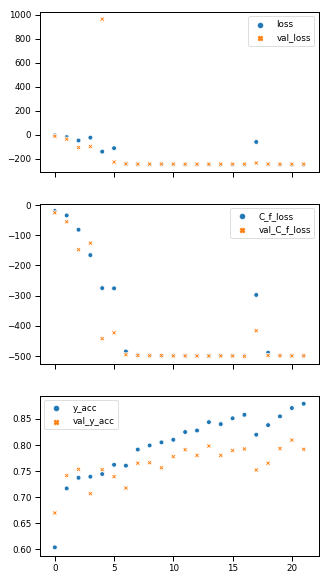

In [15]:
sns.set_context('paper')
metrics = ['loss','C_f_loss','y_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(5,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [ ]:
# if not config.dev_mode:
# trainer.save_model()

In [16]:
from keras.models import Model
from keras.layers import Input

In [17]:
generator = G

In [18]:
z_encoder = Model(x,z)
classifier = Model(x,y)
# y_lat_encoder = Model(trainer.E.input,trainer.y_lat)
# decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
# dec_layers = trainer.model.layers[-(1+(5*2)):]
# print(dec_layers)
# _gen_x = dec_layers[0](decoder_inp)
# l = dec_layers[1]
# isinstance(l,keras.layers.core.Reshape)
# F = None
# for l in dec_layers[1:]:
#     print(type(l))
    
#     if isinstance(l,keras.layers.merge.Add):
#         _gen_x = l([F,_gen_x])
#     else:
#         _gen_x = l(_gen_x)
    
#     if isinstance(l,keras.layers.convolutional.Conv2DTranspose):
#         if l.kernel_size==(1,1):
#             F = _gen_x
            
# # generator = Model(decoder_inp,_gen_x)

In [19]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              9411000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              6002000   
_________________________________________________________________
encoder_output (Dense)       (None, 21)                42021     
_________________________________________________________________
lambda_1 (Lambda)            [(None, 10), (None, 10),  0         
_________________________________________________________________
y (Activation)               (None, 10)                0         
Total params: 15,455,021
Trainable params: 15,455,021
Non-trainable params: 0
________________________________________________________________

In [20]:
DL.y_test_oh.shape

(10000, 10)

In [21]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

10000/10000 [==============================] - 0s 39us/step


[0.6003953310966492, 0.7759999997138977]

In [22]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_lat = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [23]:
_lat_vec = np.concatenate([y_lat,z_enc],axis=1)
_lat_vec.shape

(10000, 20)

In [24]:
z_enc_mu = np.mean(z_enc,axis=0)
z_enc_cov = np.cov(z_enc,rowvar=False)

In [25]:
np.random.multivariate_normal(z_enc_mu,z_enc_cov,size=50).shape

(50, 10)

In [26]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

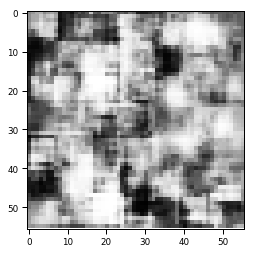

In [27]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [28]:
_lat_vec[rand_im]

array([ 1.9333661e-04,  2.9043322e-05,  2.7685443e-01,  1.7461894e-04,
        6.4259315e-01,  2.2837805e-08,  7.9565994e-02,  6.1384782e-08,
        5.8877299e-04,  5.8514001e-07, -2.7785549e+00, -6.7106199e-01,
       -8.2508192e+00,  2.5235155e+00,  7.6679783e+00,  5.9141216e+00,
       -1.7037320e+00, -2.2823837e+00,  1.9040993e+00,  2.2353542e+00],
      dtype=float32)

In [29]:
DL2 = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.5
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


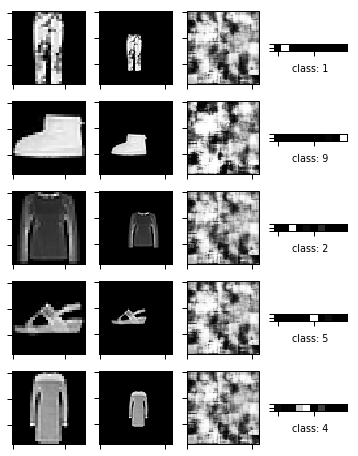

In [30]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_lat,generator)

In [31]:
z_enc2 = z_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
y_lat2 = classifier.predict(DL2.sx_test,batch_size=config.batch_size)
_lat_vec2 = np.concatenate([y_lat2,z_enc2],axis=1)
regen2 = generator.predict(_lat_vec2,batch_size=config.batch_size)

In [32]:
from src.plot import remove_axes,remove_labels
from src.utils import gen_trajectory

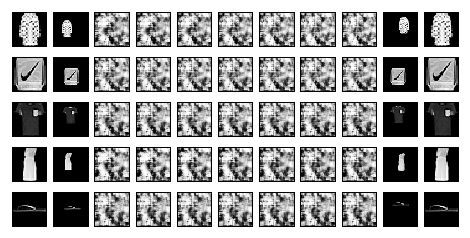

In [33]:
examples = 5
rand_im = np.random.randint(0,10000,size=examples)
fix,axs = plt.subplots(examples,11,figsize=(8,4))
_lat_s = []
regen_s = []
out = gen_trajectory(z_enc[rand_im],z_enc2[rand_im],delta=.25)
out_y = gen_trajectory(y_lat[rand_im],y_lat2[rand_im],delta=.25)

for z,y in zip(out,out_y):
    _lat = np.concatenate([y,z],axis=1)
    _lat_s.append(_lat)
    regen_s.append(generator.predict(_lat,batch_size=config.batch_size))

i=0
for axr,idx in zip(axs,rand_im):
    axr[0].imshow(DL.x_test[idx].reshape(28,28),cmap='gray')
    axr[1].imshow(DL.sx_test[idx].reshape(56,56),cmap='gray')
    axr[2].imshow(regen[idx].reshape(56,56),cmap='gray')
    for j,a in enumerate(axr[3:-3]):
        a.imshow(regen_s[j][i,:].reshape(56,56),cmap='gray')
#         a.imshow(s.reshape(56,56),cmap='gray')
    axr[-3].imshow(regen2[idx].reshape(56,56),cmap='gray')
    axr[-2].imshow(DL2.sx_test[idx].reshape(56,56),cmap='gray')
    axr[-1].imshow(DL2.x_test[idx].reshape(28,28),cmap='gray')
    for a in axr:
        remove_axes(a)
        remove_labels(a)
    i+=1
# plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [34]:
from sklearn.preprocessing import MinMaxScaler

feat_range = (0,50)
z_enc_scaled = [MinMaxScaler(feat_range).fit_transform(z_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(config.z_dim)]
z_enc_scaled = np.squeeze(np.array(z_enc_scaled,dtype=int))

In [35]:
from collections import Counter
import dit
from dit import Distribution
dxs = DL.dx[1]-14
dys = DL.dy[1]-14

def mutual_information(X,Y):
    XY_c = Counter(zip(X,Y))
    XY_pmf = {k:v/float(sum(XY_c.values())) for k,v in XY_c.items()}
    XY_jdist = Distribution(XY_pmf)
        
    return dit.shannon.mutual_information(XY_jdist,[0],[1])

In [36]:
z_dx_I = [mutual_information(z_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(config.z_dim)]

In [37]:
z_dy_I = [mutual_information(z_enc_scaled[i],dys.astype(int)+14) for i in np.arange(config.z_dim)]

In [38]:
z_class_I = [mutual_information(z_enc_scaled[i],DL.y_test) for i in np.arange(config.z_dim)]

In [39]:
z_I_df = pd.DataFrame.from_records({'class':z_class_I,'dy':z_dy_I,'dx':z_dx_I})
z_I_df['class'] = z_I_df['class'].values.round(decimals=1)

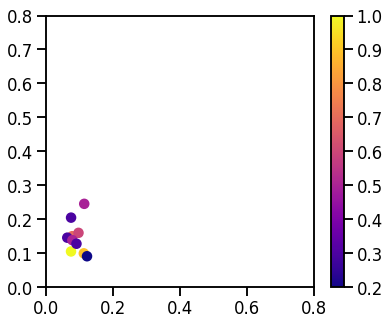

In [40]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylim(0,0.8)
ax.set_xlim(0,0.8)
points = plt.scatter(x=z_I_df['dx'],y=z_I_df['dy'],c=z_I_df['class'],cmap='plasma')
plt.colorbar(points)

(0, 0.6)

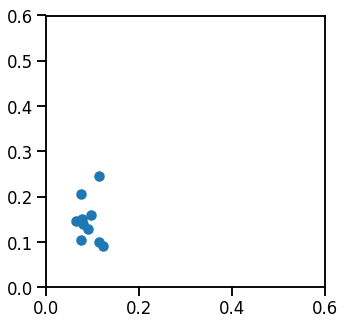

In [41]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(z_dx_I,z_dy_I)
ax.set_ylim(0,0.6)
ax.set_xlim(0,0.6)

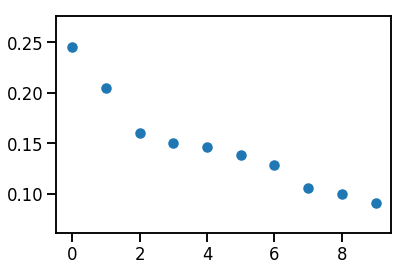

In [42]:
plt.scatter(np.arange(config.z_dim),sorted(z_dy_I,reverse=True))

In [43]:
from src.metrics import var_expl,norm_var_expl
from collections import Counter



dtheta = DL.dtheta[1]
fve_dx = norm_var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = norm_var_expl(features=z_enc,cond=dys,bins=21)
# fve_dt = norm_var_expl(features=z_enc,cond=dtheta,bins=21)

In [44]:
# fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
# fve_dy_norm = (dys.var()-fve_dy)/dys.var()
# fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()
fve_dx_norm = fve_dx
fve_dy_norm = fve_dy

In [45]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape
# np.save(os.path.join(config.model_dir,'fve_dx_norm'),fve_dx_norm)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(fve_dx_norm.mean(axis=0),fve_dy_norm.mean(axis=0))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dx.png'))
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)
# np.save(os.path.join(config.model_dir,'fve_dy_norm'),fve_dy_norm)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dy.png'))
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
# plt.scatter(np.arange(config.z_dim),fve_dth_norm.mean(axis=0))
# plt.xlabel('Z_n')
# plt.ylabel('fve_dtheta')
# # plt.ylim(0.0,0.5)
# np.argmax(fve_dth_norm.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

In [ ]:
Z_color_scatter(z_enc,[7,18],dtheta)

In [ ]:
from plt.